In [59]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import optuna
from optuna.trial import TrialState

##### Carregando o dataset

In [5]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [6]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

#### Declarando as funções de avaliação do modelo

In [7]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [8]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [10]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [11]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [12]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [13]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [14]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [15]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo xgboost base

Utilizaremos configurações similares a configuração base do random forest, para comparação

In [47]:
params = {
    'max_depth': 10,
    'eta': 0.1,  #Learning Rate
    'objective': 'binary:logistic', # Escolha para classificação binária
    'eval_metric': 'auc'            # Avaliando via AUC
}

##### Criando instância DMatrix

In [48]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [49]:
model = xgb.train(params, dtrain, 50, evals=[(dval, 'validation')], early_stopping_rounds=5)


[0]	validation-auc:0.98732


[1]	validation-auc:0.98779
[2]	validation-auc:0.98877
[3]	validation-auc:0.98898
[4]	validation-auc:0.98917
[5]	validation-auc:0.98932
[6]	validation-auc:0.98960
[7]	validation-auc:0.98976
[8]	validation-auc:0.99003
[9]	validation-auc:0.99028
[10]	validation-auc:0.99051
[11]	validation-auc:0.99060
[12]	validation-auc:0.99083
[13]	validation-auc:0.99097
[14]	validation-auc:0.99113
[15]	validation-auc:0.99124
[16]	validation-auc:0.99158
[17]	validation-auc:0.99179
[18]	validation-auc:0.99194
[19]	validation-auc:0.99204
[20]	validation-auc:0.99219
[21]	validation-auc:0.99229
[22]	validation-auc:0.99244
[23]	validation-auc:0.99254
[24]	validation-auc:0.99262
[25]	validation-auc:0.99268
[26]	validation-auc:0.99275
[27]	validation-auc:0.99281
[28]	validation-auc:0.99289
[29]	validation-auc:0.99293
[30]	validation-auc:0.99299
[31]	validation-auc:0.99303
[32]	validation-auc:0.99306
[33]	validation-auc:0.99308
[34]	validation-auc:0.99313
[35]	validation-auc:0.99314
[36]	validation-auc:0.99317
[

#### Avaliando o Modelo


In [50]:
xgb_pred_scores = model.predict(dtest)

# Calculando a probabilidade da classe negativa
neg_class_probs = 1 - xgb_pred_scores

# Concatenando as duas arrays para formar um array 2D
xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

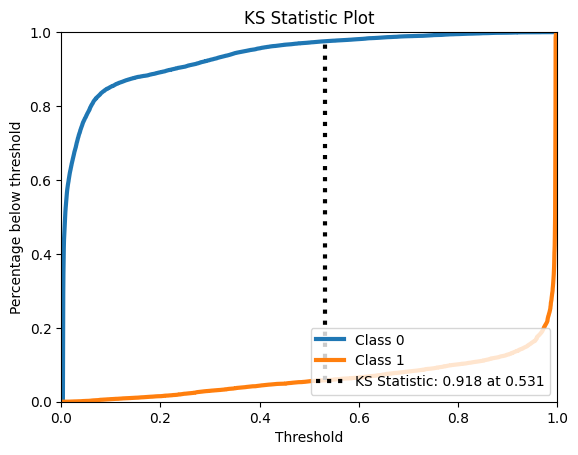



xgboost - Test

Accuracy:         0.9599
Recall:           0.9445
Precision:        0.9625
F1:               0.9534
AUROC:            0.9942
AUPR:             0.9932


In [51]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
print('\n\nxgboost - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

In [63]:
def objective(trial):

    global dtrain
    global dval
    global dtest
    global y_test

    params = {
        'max_depth': trial.suggest_int('max_depth', 3,  50),
        'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate
        'objective': 'binary:logistic', # Escolha para classificação binária
        'eval_metric': 'auc',        # Avaliando via AUC
        'lambda' : trial.suggest_int('lambda', 1,  5), # L2 regularization term on weights
        'alpha' : trial.suggest_int('alpha', 1,  5),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }



    trial.set_user_attr("max_depth", params["max_depth"])
    trial.set_user_attr("eta", params["eta"])
    trial.set_user_attr("lambda", params["lambda"])
    trial.set_user_attr("alpha", params["alpha"])
    trial.set_user_attr("grow_policy", params["grow_policy"])

    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = xgb.train(params, dtrain, 100, evals=[(dval, 'validation')], early_stopping_rounds=5)

    
    xgb_pred_scores = model.predict(dtest)

    neg_class_probs = 1 - xgb_pred_scores

    xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
    xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, xgb_pred_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
    print(f'\n\nXgboost\neta: {params["eta"]}\nmax_depth:{params["max_depth"]}\nlambda:{params["lambda"]}\nalpha:{params["alpha"]}\ngrow_policy:{params["grow_policy"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)
    
    return auroc, ks_statistic


[I 2024-07-17 20:43:13,860] A new study created in memory with name: no-name-37d5e9a9-0bee-4dad-9174-7c27d788e92d


[0]	validation-auc:0.98778
[1]	validation-auc:0.98953
[2]	validation-auc:0.99027
[3]	validation-auc:0.99089
[4]	validation-auc:0.99148
[5]	validation-auc:0.99197
[6]	validation-auc:0.99218
[7]	validation-auc:0.99272
[8]	validation-auc:0.99290
[9]	validation-auc:0.99313


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[10]	validation-auc:0.99326
[11]	validation-auc:0.99337
[12]	validation-auc:0.99347
[13]	validation-auc:0.99359
[14]	validation-auc:0.99368
[15]	validation-auc:0.99376
[16]	validation-auc:0.99382
[17]	validation-auc:0.99384
[18]	validation-auc:0.99392
[19]	validation-auc:0.99395
[20]	validation-auc:0.99399
[21]	validation-auc:0.99404
[22]	validation-auc:0.99404
[23]	validation-auc:0.99407
[24]	validation-auc:0.99410
[25]	validation-auc:0.99409
[26]	validation-auc:0.99408
[27]	validation-auc:0.99407
[28]	validation-auc:0.99408


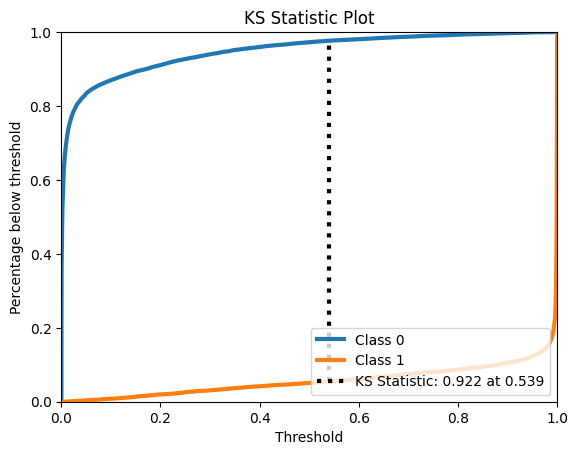

[I 2024-07-17 20:43:14,777] Trial 0 finished with values: [0.9949287800811283, 0.9223488581356605] and parameters: {'max_depth': 42, 'eta': 0.3, 'lambda': 3, 'alpha': 3, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.3
max_depth:42
lambda:3
alpha:3
grow_policy:depthwise

Accuracy:         0.9625
Recall:           0.9492
Precision:        0.9639
F1:               0.9565
AUROC:            0.9949
AUPR:             0.9940
[0]	validation-auc:0.98469
[1]	validation-auc:0.98795
[2]	validation-auc:0.98906
[3]	validation-auc:0.98923
[4]	validation-auc:0.98952
[5]	validation-auc:0.98989
[6]	validation-auc:0.99011
[7]	validation-auc:0.99020
[8]	validation-auc:0.99048


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[9]	validation-auc:0.99067
[10]	validation-auc:0.99088
[11]	validation-auc:0.99122
[12]	validation-auc:0.99144
[13]	validation-auc:0.99157
[14]	validation-auc:0.99176
[15]	validation-auc:0.99192
[16]	validation-auc:0.99203
[17]	validation-auc:0.99212
[18]	validation-auc:0.99218
[19]	validation-auc:0.99228
[20]	validation-auc:0.99261
[21]	validation-auc:0.99273
[22]	validation-auc:0.99280
[23]	validation-auc:0.99296
[24]	validation-auc:0.99303
[25]	validation-auc:0.99308
[26]	validation-auc:0.99317
[27]	validation-auc:0.99323
[28]	validation-auc:0.99326
[29]	validation-auc:0.99333
[30]	validation-auc:0.99337
[31]	validation-auc:0.99341
[32]	validation-auc:0.99346
[33]	validation-auc:0.99350
[34]	validation-auc:0.99354
[35]	validation-auc:0.99358
[36]	validation-auc:0.99360
[37]	validation-auc:0.99363
[38]	validation-auc:0.99366
[39]	validation-auc:0.99369
[40]	validation-auc:0.99371
[41]	validation-auc:0.99373
[42]	validation-auc:0.99374
[43]	validation-auc:0.99376
[44]	validation-auc:0

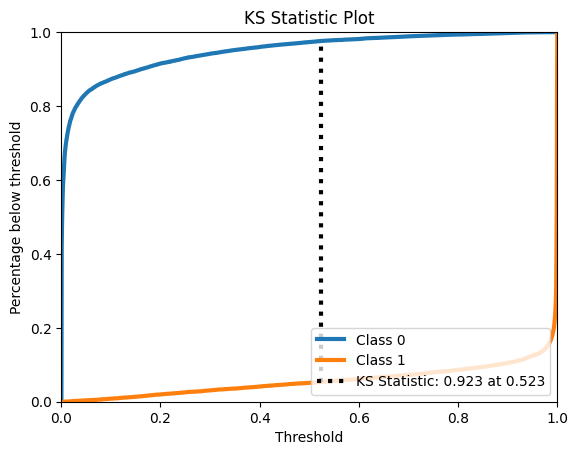

[I 2024-07-17 20:43:16,752] Trial 1 finished with values: [0.9950577471045091, 0.9228027914843402] and parameters: {'max_depth': 31, 'eta': 0.1, 'lambda': 5, 'alpha': 2, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.1
max_depth:31
lambda:5
alpha:2
grow_policy:depthwise

Accuracy:         0.9627
Recall:           0.9492
Precision:        0.9644
F1:               0.9567
AUROC:            0.9951
AUPR:             0.9942
[0]	validation-auc:0.98819
[1]	validation-auc:0.98916
[2]	validation-auc:0.99025
[3]	validation-auc:0.99058
[4]	validation-auc:0.99091
[5]	validation-auc:0.99129


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[6]	validation-auc:0.99162
[7]	validation-auc:0.99185
[8]	validation-auc:0.99213
[9]	validation-auc:0.99232
[10]	validation-auc:0.99271
[11]	validation-auc:0.99295
[12]	validation-auc:0.99310
[13]	validation-auc:0.99322
[14]	validation-auc:0.99335
[15]	validation-auc:0.99340
[16]	validation-auc:0.99351
[17]	validation-auc:0.99361
[18]	validation-auc:0.99365
[19]	validation-auc:0.99373
[20]	validation-auc:0.99380
[21]	validation-auc:0.99385
[22]	validation-auc:0.99389
[23]	validation-auc:0.99394
[24]	validation-auc:0.99395
[25]	validation-auc:0.99395
[26]	validation-auc:0.99398
[27]	validation-auc:0.99399
[28]	validation-auc:0.99401
[29]	validation-auc:0.99404
[30]	validation-auc:0.99406
[31]	validation-auc:0.99408
[32]	validation-auc:0.99408
[33]	validation-auc:0.99409
[34]	validation-auc:0.99410
[35]	validation-auc:0.99411
[36]	validation-auc:0.99411
[37]	validation-auc:0.99411
[38]	validation-auc:0.99413
[39]	validation-auc:0.99413
[40]	validation-auc:0.99414
[41]	validation-auc:0.99

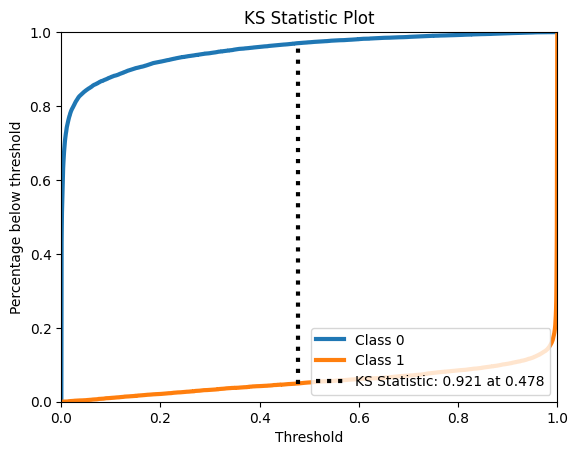

[I 2024-07-17 20:43:17,955] Trial 2 finished with values: [0.9949599057260846, 0.9210544320052141] and parameters: {'max_depth': 42, 'eta': 0.2, 'lambda': 3, 'alpha': 2, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.2
max_depth:42
lambda:3
alpha:2
grow_policy:depthwise

Accuracy:         0.9617
Recall:           0.9478
Precision:        0.9635
F1:               0.9556
AUROC:            0.9950
AUPR:             0.9940
[0]	validation-auc:0.98465
[1]	validation-auc:0.98803
[2]	validation-auc:0.98931
[3]	validation-auc:0.98978
[4]	validation-auc:0.99025
[5]	validation-auc:0.99101
[6]	validation-auc:0.99133
[7]	validation-auc:0.99173
[8]	validation-auc:0.99198
[9]	validation-auc:0.99243
[10]	validation-auc:0.99258
[11]	validation-auc:0.99279
[12]	validation-auc:0.99298


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[13]	validation-auc:0.99309
[14]	validation-auc:0.99325
[15]	validation-auc:0.99334
[16]	validation-auc:0.99342
[17]	validation-auc:0.99350
[18]	validation-auc:0.99358
[19]	validation-auc:0.99365
[20]	validation-auc:0.99371
[21]	validation-auc:0.99378
[22]	validation-auc:0.99383
[23]	validation-auc:0.99388
[24]	validation-auc:0.99393
[25]	validation-auc:0.99397
[26]	validation-auc:0.99403
[27]	validation-auc:0.99407
[28]	validation-auc:0.99411
[29]	validation-auc:0.99413
[30]	validation-auc:0.99416
[31]	validation-auc:0.99418
[32]	validation-auc:0.99419
[33]	validation-auc:0.99422
[34]	validation-auc:0.99422
[35]	validation-auc:0.99422
[36]	validation-auc:0.99424
[37]	validation-auc:0.99425
[38]	validation-auc:0.99424
[39]	validation-auc:0.99426
[40]	validation-auc:0.99427
[41]	validation-auc:0.99427
[42]	validation-auc:0.99427
[43]	validation-auc:0.99428
[44]	validation-auc:0.99429
[45]	validation-auc:0.99428
[46]	validation-auc:0.99430
[47]	validation-auc:0.99430
[48]	validation-auc:

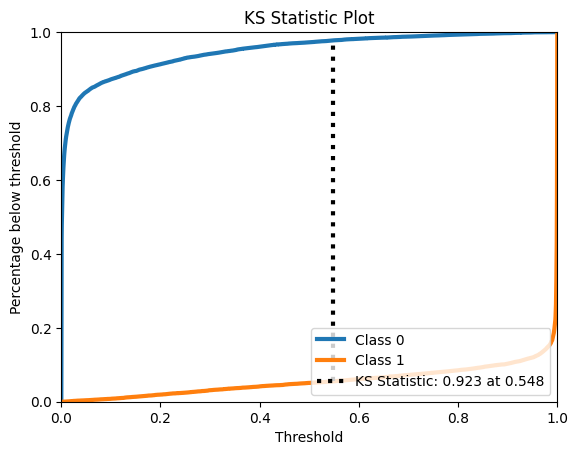

[I 2024-07-17 20:43:19,401] Trial 3 finished with values: [0.9950760912772528, 0.9227732562853372] and parameters: {'max_depth': 27, 'eta': 0.2, 'lambda': 3, 'alpha': 4, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.2
max_depth:27
lambda:3
alpha:4
grow_policy:depthwise

Accuracy:         0.9623
Recall:           0.9491
Precision:        0.9636
F1:               0.9563
AUROC:            0.9951
AUPR:             0.9942
[0]	validation-auc:0.98234
[1]	validation-auc:0.98504
[2]	validation-auc:0.98559
[3]	validation-auc:0.98676
[4]	validation-auc:0.98752
[5]	validation-auc:0.98886
[6]	validation-auc:0.98966
[7]	validation-auc:0.99008
[8]	validation-auc:0.99053
[9]	validation-auc:0.99088
[10]	validation-auc:0.99124
[11]	validation-auc:0.99146


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[12]	validation-auc:0.99163
[13]	validation-auc:0.99172
[14]	validation-auc:0.99195
[15]	validation-auc:0.99219
[16]	validation-auc:0.99228
[17]	validation-auc:0.99235
[18]	validation-auc:0.99249
[19]	validation-auc:0.99255
[20]	validation-auc:0.99271
[21]	validation-auc:0.99281
[22]	validation-auc:0.99295
[23]	validation-auc:0.99312
[24]	validation-auc:0.99320
[25]	validation-auc:0.99332
[26]	validation-auc:0.99341
[27]	validation-auc:0.99350
[28]	validation-auc:0.99356
[29]	validation-auc:0.99361
[30]	validation-auc:0.99367
[31]	validation-auc:0.99376
[32]	validation-auc:0.99376
[33]	validation-auc:0.99376
[34]	validation-auc:0.99380
[35]	validation-auc:0.99384
[36]	validation-auc:0.99390
[37]	validation-auc:0.99390
[38]	validation-auc:0.99393
[39]	validation-auc:0.99400
[40]	validation-auc:0.99401
[41]	validation-auc:0.99402
[42]	validation-auc:0.99403
[43]	validation-auc:0.99402
[44]	validation-auc:0.99409
[45]	validation-auc:0.99411
[46]	validation-auc:0.99412
[47]	validation-auc:

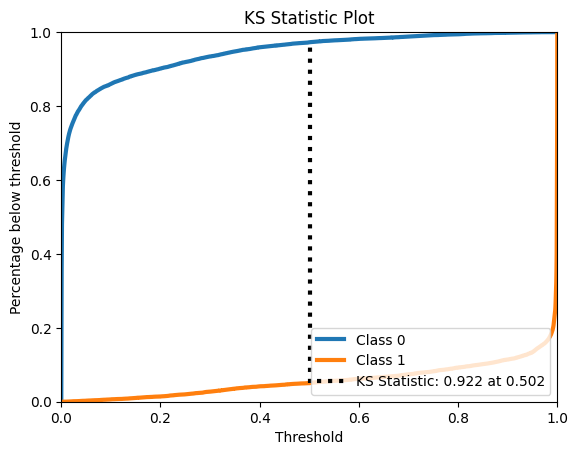

[I 2024-07-17 20:43:20,594] Trial 4 finished with values: [0.995023780274549, 0.9222835070202612] and parameters: {'max_depth': 8, 'eta': 0.25, 'lambda': 4, 'alpha': 2, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.25
max_depth:8
lambda:4
alpha:2
grow_policy:lossguide

Accuracy:         0.9625
Recall:           0.9496
Precision:        0.9636
F1:               0.9565
AUROC:            0.9950
AUPR:             0.9941
[0]	validation-auc:0.98831
[1]	validation-auc:0.98909
[2]	validation-auc:0.98989
[3]	validation-auc:0.99036
[4]	validation-auc:0.99076
[5]	validation-auc:0.99138


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[6]	validation-auc:0.99165
[7]	validation-auc:0.99203
[8]	validation-auc:0.99219
[9]	validation-auc:0.99230
[10]	validation-auc:0.99257
[11]	validation-auc:0.99296
[12]	validation-auc:0.99311
[13]	validation-auc:0.99324
[14]	validation-auc:0.99334
[15]	validation-auc:0.99347
[16]	validation-auc:0.99354
[17]	validation-auc:0.99362
[18]	validation-auc:0.99370
[19]	validation-auc:0.99376
[20]	validation-auc:0.99383
[21]	validation-auc:0.99390
[22]	validation-auc:0.99395
[23]	validation-auc:0.99400
[24]	validation-auc:0.99402
[25]	validation-auc:0.99409
[26]	validation-auc:0.99416
[27]	validation-auc:0.99421
[28]	validation-auc:0.99422
[29]	validation-auc:0.99427
[30]	validation-auc:0.99428
[31]	validation-auc:0.99430
[32]	validation-auc:0.99430
[33]	validation-auc:0.99433
[34]	validation-auc:0.99433
[35]	validation-auc:0.99435
[36]	validation-auc:0.99437
[37]	validation-auc:0.99436
[38]	validation-auc:0.99437
[39]	validation-auc:0.99438
[40]	validation-auc:0.99439
[41]	validation-auc:0.99

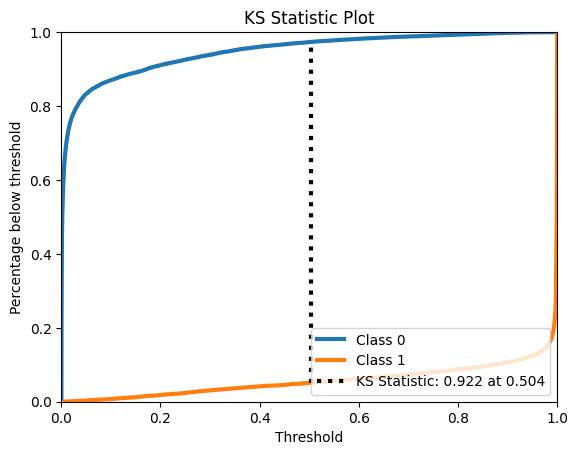

[I 2024-07-17 20:43:22,248] Trial 5 finished with values: [0.9950485055326346, 0.9224788153274566] and parameters: {'max_depth': 28, 'eta': 0.2, 'lambda': 1, 'alpha': 4, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.2
max_depth:28
lambda:1
alpha:4
grow_policy:lossguide

Accuracy:         0.9626
Recall:           0.9490
Precision:        0.9643
F1:               0.9566
AUROC:            0.9950
AUPR:             0.9941
[0]	validation-auc:0.98373
[1]	validation-auc:0.98507
[2]	validation-auc:0.98851
[3]	validation-auc:0.98885
[4]	validation-auc:0.98907
[5]	validation-auc:0.98920
[6]	validation-auc:0.98949


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[7]	validation-auc:0.98987
[8]	validation-auc:0.99020
[9]	validation-auc:0.99032
[10]	validation-auc:0.99078
[11]	validation-auc:0.99097
[12]	validation-auc:0.99120
[13]	validation-auc:0.99131
[14]	validation-auc:0.99147
[15]	validation-auc:0.99171
[16]	validation-auc:0.99186
[17]	validation-auc:0.99194
[18]	validation-auc:0.99202
[19]	validation-auc:0.99237
[20]	validation-auc:0.99248
[21]	validation-auc:0.99255
[22]	validation-auc:0.99267
[23]	validation-auc:0.99272
[24]	validation-auc:0.99278
[25]	validation-auc:0.99292
[26]	validation-auc:0.99299
[27]	validation-auc:0.99307
[28]	validation-auc:0.99314
[29]	validation-auc:0.99318
[30]	validation-auc:0.99322
[31]	validation-auc:0.99329
[32]	validation-auc:0.99334
[33]	validation-auc:0.99338
[34]	validation-auc:0.99344
[35]	validation-auc:0.99349
[36]	validation-auc:0.99354
[37]	validation-auc:0.99357
[38]	validation-auc:0.99360
[39]	validation-auc:0.99363
[40]	validation-auc:0.99366
[41]	validation-auc:0.99369
[42]	validation-auc:0.9

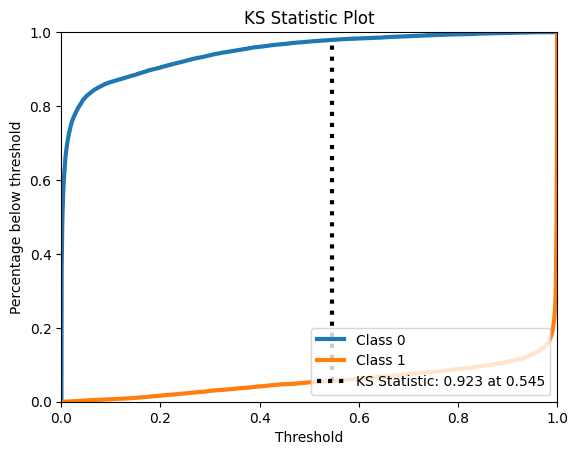

[I 2024-07-17 20:43:24,611] Trial 6 finished with values: [0.995057171918958, 0.9230662187461302] and parameters: {'max_depth': 47, 'eta': 0.1, 'lambda': 4, 'alpha': 4, 'grow_policy': 'depthwise'}. 




Xgboost
eta: 0.1
max_depth:47
lambda:4
alpha:4
grow_policy:depthwise

Accuracy:         0.9627
Recall:           0.9473
Precision:        0.9661
F1:               0.9566
AUROC:            0.9951
AUPR:             0.9942
[0]	validation-auc:0.98791
[1]	validation-auc:0.98862
[2]	validation-auc:0.98976
[3]	validation-auc:0.98996


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[4]	validation-auc:0.99046
[5]	validation-auc:0.99121
[6]	validation-auc:0.99148
[7]	validation-auc:0.99171
[8]	validation-auc:0.99201
[9]	validation-auc:0.99229
[10]	validation-auc:0.99266
[11]	validation-auc:0.99289
[12]	validation-auc:0.99305
[13]	validation-auc:0.99317
[14]	validation-auc:0.99327
[15]	validation-auc:0.99337
[16]	validation-auc:0.99347
[17]	validation-auc:0.99356
[18]	validation-auc:0.99364
[19]	validation-auc:0.99372
[20]	validation-auc:0.99375
[21]	validation-auc:0.99379
[22]	validation-auc:0.99384
[23]	validation-auc:0.99387
[24]	validation-auc:0.99392
[25]	validation-auc:0.99394
[26]	validation-auc:0.99400
[27]	validation-auc:0.99406
[28]	validation-auc:0.99411
[29]	validation-auc:0.99414
[30]	validation-auc:0.99417
[31]	validation-auc:0.99418
[32]	validation-auc:0.99421
[33]	validation-auc:0.99421
[34]	validation-auc:0.99423
[35]	validation-auc:0.99423
[36]	validation-auc:0.99424
[37]	validation-auc:0.99422
[38]	validation-auc:0.99422
[39]	validation-auc:0.9942

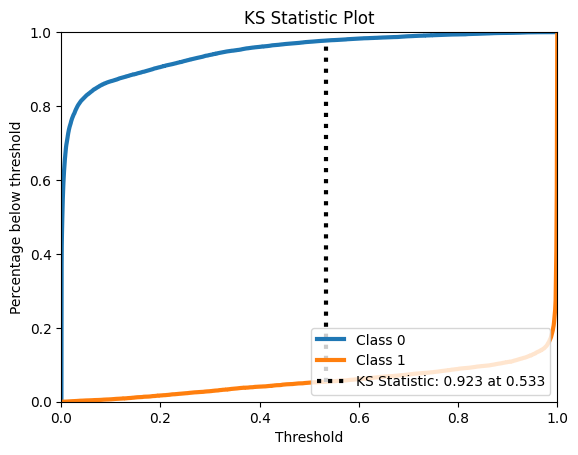

[I 2024-07-17 20:43:26,353] Trial 7 finished with values: [0.99508096877352, 0.9234337584529742] and parameters: {'max_depth': 21, 'eta': 0.2, 'lambda': 1, 'alpha': 5, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.2
max_depth:21
lambda:1
alpha:5
grow_policy:lossguide

Accuracy:         0.9627
Recall:           0.9485
Precision:        0.9650
F1:               0.9567
AUROC:            0.9951
AUPR:             0.9942
[0]	validation-auc:0.98768
[1]	validation-auc:0.98936
[2]	validation-auc:0.98990


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[3]	validation-auc:0.99073
[4]	validation-auc:0.99135
[5]	validation-auc:0.99164
[6]	validation-auc:0.99210
[7]	validation-auc:0.99224
[8]	validation-auc:0.99281
[9]	validation-auc:0.99297
[10]	validation-auc:0.99312
[11]	validation-auc:0.99326
[12]	validation-auc:0.99335
[13]	validation-auc:0.99350
[14]	validation-auc:0.99361
[15]	validation-auc:0.99365
[16]	validation-auc:0.99370
[17]	validation-auc:0.99374
[18]	validation-auc:0.99380
[19]	validation-auc:0.99380
[20]	validation-auc:0.99386
[21]	validation-auc:0.99388
[22]	validation-auc:0.99391
[23]	validation-auc:0.99396
[24]	validation-auc:0.99400
[25]	validation-auc:0.99401
[26]	validation-auc:0.99402
[27]	validation-auc:0.99404
[28]	validation-auc:0.99404
[29]	validation-auc:0.99405
[30]	validation-auc:0.99407
[31]	validation-auc:0.99408
[32]	validation-auc:0.99409
[33]	validation-auc:0.99408
[34]	validation-auc:0.99409
[35]	validation-auc:0.99410
[36]	validation-auc:0.99410
[37]	validation-auc:0.99409
[38]	validation-auc:0.99408

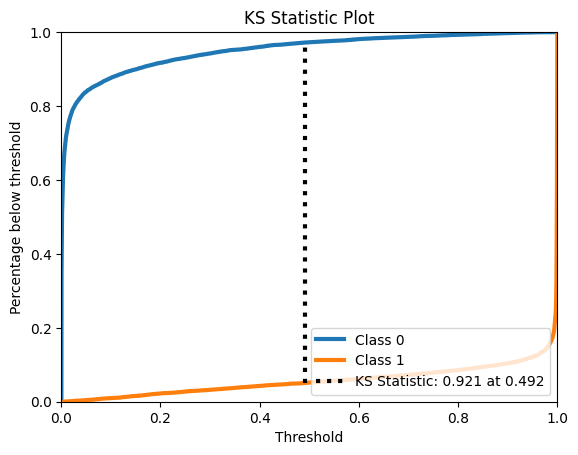

[I 2024-07-17 20:43:28,331] Trial 8 finished with values: [0.9948634212451176, 0.9211286425222225] and parameters: {'max_depth': 40, 'eta': 0.25, 'lambda': 4, 'alpha': 2, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.25
max_depth:40
lambda:4
alpha:2
grow_policy:lossguide

Accuracy:         0.9620
Recall:           0.9482
Precision:        0.9637
F1:               0.9559
AUROC:            0.9949
AUPR:             0.9939
[0]	validation-auc:0.98469
[1]	validation-auc:0.98939
[2]	validation-auc:0.98979
[3]	validation-auc:0.99052
[4]	validation-auc:0.99126


/tmp/ipykernel_9200/2440149818.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[5]	validation-auc:0.99172
[6]	validation-auc:0.99206
[7]	validation-auc:0.99223
[8]	validation-auc:0.99276
[9]	validation-auc:0.99296
[10]	validation-auc:0.99320
[11]	validation-auc:0.99332
[12]	validation-auc:0.99343
[13]	validation-auc:0.99351
[14]	validation-auc:0.99360
[15]	validation-auc:0.99366
[16]	validation-auc:0.99374
[17]	validation-auc:0.99378
[18]	validation-auc:0.99385
[19]	validation-auc:0.99391
[20]	validation-auc:0.99394
[21]	validation-auc:0.99401
[22]	validation-auc:0.99403
[23]	validation-auc:0.99406
[24]	validation-auc:0.99406
[25]	validation-auc:0.99407
[26]	validation-auc:0.99409
[27]	validation-auc:0.99409
[28]	validation-auc:0.99411
[29]	validation-auc:0.99412
[30]	validation-auc:0.99414
[31]	validation-auc:0.99415
[32]	validation-auc:0.99414
[33]	validation-auc:0.99414
[34]	validation-auc:0.99414
[35]	validation-auc:0.99415
[36]	validation-auc:0.99415
[37]	validation-auc:0.99415
[38]	validation-auc:0.99414
[39]	validation-auc:0.99413
[40]	validation-auc:0.994

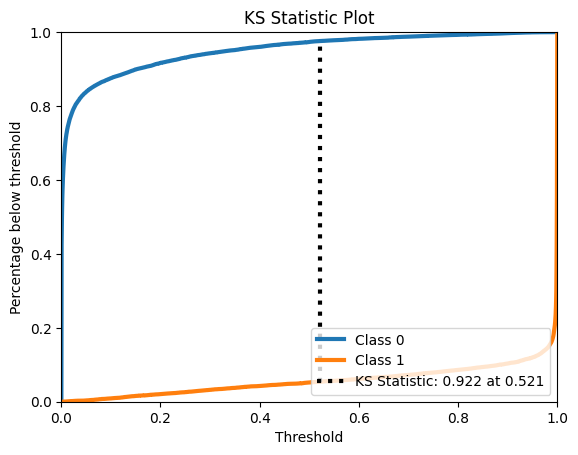

[I 2024-07-17 20:43:30,314] Trial 9 finished with values: [0.9949690758823035, 0.9220178678032982] and parameters: {'max_depth': 22, 'eta': 0.25, 'lambda': 5, 'alpha': 2, 'grow_policy': 'lossguide'}. 




Xgboost
eta: 0.25
max_depth:22
lambda:5
alpha:2
grow_policy:lossguide

Accuracy:         0.9623
Recall:           0.9478
Precision:        0.9648
F1:               0.9562
AUROC:            0.9950
AUPR:             0.9941


In [70]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [74]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "optuna_results_xgb.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [76]:
df_existing

,number,values_0,values_1,params_alpha,params_eta,params_grow_policy,params_lambda,params_max_depth,user_attrs_accuracy,user_attrs_alpha,...,user_attrs_eta,user_attrs_f1,user_attrs_grow_policy,user_attrs_ks_statistic,user_attrs_lambda,user_attrs_max_depth,user_attrs_max_distance_at,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation
8,8,0.994863,0.921129,2,0.25,lossguide,4,40,0.961965,2,...,0.25,0.963689,lossguide,0.921129,4,40,0.492271,0.963689,0.948182,0
0,0,0.994929,0.922349,3,0.30,depthwise,3,42,0.962488,3,...,0.30,0.963933,depthwise,0.922349,3,42,0.539422,0.963933,0.949174,0
2,2,0.994960,0.921054,2,0.20,depthwise,3,42,0.961749,2,...,0.20,0.963537,depthwise,0.921054,3,42,0.477824,0.963537,0.947827,0
9,9,0.994969,0.922018,2,0.25,lossguide,5,22,0.962304,2,...,0.25,0.964788,lossguide,0.922018,5,22,0.520749,0.964788,0.947827,0
4,4,0.995024,0.922284,2,0.25,lossguide,4,8,0.962519,2,...,0.25,0.963602,lossguide,0.922284,4,8,0.502064,0.963602,0.949599,0
5,5,0.995049,0.922479,4,0.20,lossguide,1,28,0.962581,4,...,0.20,0.964342,lossguide,0.922479,1,28,0.503861,0.964342,0.948962,0
6,6,0.995057,0.923066,4,0.10,depthwise,4,47,0.962673,4,...,0.10,0.966096,depthwise,0.923066,4,47,0.545145,0.966096,0.947331,0
1,1,0.995058,0.922803,2,0.10,depthwise,5,31,0.962673,2,...,0.10,0.964350,depthwise,0.922803,5,31,0.523488,0.964350,0.949174,0
3,3,0.995076,0.922773,4,0.20,depthwise,3,27,0.962304,4,...,0.20,0.963584,depthwise,0.922773,3,27,0.548302,0.963584,0.949103,0
7,7,0.995081,0.923434,5,0.20,lossguide,1,21,0.962704,5,...,0.20,0.965022,lossguide,0.923434,1,21,0.533000,0.965022,0.948536,0


In [95]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9627040344933785
  Precision: 0.965022356844079
  Recall:    0.94853618770823
  F1 Score:  0.965022356844079
  auroc:  0.99508096877352
  ks_statistic:  0.9234337584529742
  max_distance_at:  0.5329999923706055
  Parameters: 
    max_depth:        21
    eta:              0.2
    lambda:           1
    alpha:            5
    grow_policy:      lossguide

-- Overall Results (Ordered by auroc) --
   number  values_0  values_1  params_alpha  params_eta params_grow_policy  \
8       8  0.994863  0.921129             2        0.25          lossguide   
0       0  0.994929  0.922349             3        0.30          depthwise   
2       2  0.994960  0.921054             2        0.20          depthwise   
9       9  0.994969  0.922018             2        0.25          lossguide   
4       4  0.995024  0.922284             2        0.25          lossguide   
5       5  0.995049  0.922479             4        0.20          lossguide   
6       6  0.995057  0